# Autoencoders
### Autoencoders are a foundational unsupervised learning algorithm designed to learn compressed representations of data by encoding it into a lower-dimensional latent space and decoding it to reconstruct the original input. They assume that normal data patterns can be effectively compressed and reconstructed with low error, while anomalies produce high reconstruction errors, making them highly effective for tasks like fraud detection when data exhibits distinct normal patterns. This simplicity enables quick implementation and interpretation, ideal for initial prototypes or scenarios with well-structured data. However, their sensitivity to noisy data and potential for overfitting without regularization can limit performance in complex datasets.

### Use Autoencoders as a baseline model for unsupervised anomaly detection, refining it based on the use case.


| Aspect | Details |
| :- | :- |
| Use For           | Anomaly detection (e.g., fraud detection in financial transactions)<br>Can be extended to denoising or feature learning |
| Key Assumptions   | - Normal data can be compressed and reconstructed with low error<br>- Anomalies deviate significantly from learned patterns<br>- Sufficient data for representation learning |
| Advantages        | - Learns unsupervised data representations<br>- Effective for high-dimensional data<br>- Flexible for various tasks |
| Disadvantages     | - Computationally intensive during training<br>- Prone to overfitting without regularization<br>- Sensitive to hyperparameter tuning |
| Avoid When        | - Very small datasets with limited samples<br>- Highly noisy data without preprocessing<br>- Real-time applications with low latency |
| Real-World Use Case | Fraud detection (e.g., identifying suspicious transactions in financial networks)<br>Data denoising (e.g., cleaning noisy financial records) |

## Problem Description: 
### Detect fraudulent financial transactions using the Kaggle Credit Card Fraud Detection dataset based on features like transaction amount and anonymized variables. This is a classic unsupervised anomaly detection problem where autoencoders can model normal transaction patterns and identify deviations as potential fraud.

Using Kaggle dataset [Credit Card Fraud Detection](https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud)

In [23]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import random
import os


In [24]:
project_dir = './18_autoencoders'

In [25]:
def setup_gpu():
    ## tf version
    print("TensorFlow version:", tf.__version__)

    #### GPU Optimisation code ####
    print("GPUs:",tf.config.list_physical_devices('GPU'))

    print("GPUs: Allocate GPU Memory and create a new session")

    # Get the GPU memory fraction to allocate
    gpu_memory_fraction = 0.5

    # Create GPUOptions with the fraction of GPU memory to allocate
    gpu_options = tf.compat.v1.GPUOptions(per_process_gpu_memory_fraction=gpu_memory_fraction)

    # Create a session with the GPUOptions
    session = tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(gpu_options=gpu_options))

In [26]:
setup_gpu()

TensorFlow version: 2.19.0
GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
GPUs: Allocate GPU Memory and create a new session


I0000 00:00:1751401130.321723 2443509 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5119 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3080, pci bus id: 0000:01:00.0, compute capability: 8.6


In [27]:
# load training dataset
data = pd.read_csv(project_dir +  '/data/creditcard.csv')

In [28]:
X = data.drop(columns=['Class']).values
y = data['Class'].values

# preprocess data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_train = X_scaled[y == 0]  # Train on normal transactions only
X_test = X_scaled
y_test = y

In [29]:
# build autoencoder model
autoencoder = Sequential([
    Dense(64, activation='relu', input_shape=(X.shape[1],)),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dropout(0.3),
    Dense(16, activation='relu'),  # Latent space
    Dense(32, activation='relu'),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(X.shape[1], activation='linear')
])


# compile the model with a custom learning rate
custom_optimizer = Adam(learning_rate=0.001)
autoencoder.compile(optimizer=custom_optimizer, loss='mean_squared_error', metrics=['accuracy'])


# define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, min_lr=0.0001)

/home/tarun/miniconda3/envs/own-ml-dl-experiments/lib/python3.12/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [30]:
# train the model
history = autoencoder.fit(X_train, X_train, epochs=100, batch_size=32, 
                         validation_split=0.2, callbacks=[early_stopping, reduce_lr], verbose=1)

Epoch 1/100
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 23s 3ms/step - accuracy: 0.1234 - loss: 0.8379 - val_accuracy: 0.2672 - val_loss: 0.6426 - learning_rate: 0.0010
Epoch 2/100
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step - accuracy: 0.1845 - loss: 0.6651 - val_accuracy: 0.2838 - val_loss: 0.5763 - learning_rate: 0.0010
Epoch 3/100
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step - accuracy: 0.2294 - loss: 0.6213 - val_accuracy: 0.2692 - val_loss: 0.5526 - learning_rate: 0.0010
Epoch 4/100
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step - accuracy: 0.2466 - loss: 0.6107 - val_accuracy: 0.2245 - val_loss: 0.5530 - learning_rate: 0.0010
Epoch 5/100
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step - accuracy: 0.2590 - loss: 0.6128 - val_accuracy: 0.2230 - val_loss: 0.5367 - learning_rate: 0.0010
Epoch 6/100
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step - accuracy: 0.2676 - loss: 0.6052 - val_accuracy: 0.2377 - val_loss: 0.5316 - learning_rate: 0.0010
Epoch 7/100
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step - accura

In [31]:
# evaluate reconstruction errors
X_train_pred = autoencoder.predict(X_train)
train_mse = np.mean(np.square(X_train - X_train_pred), axis=1)
threshold = np.percentile(train_mse, 95)  # Set threshold at 95th percentile

X_test_pred = autoencoder.predict(X_test)
test_mse = np.mean(np.square(X_test - X_test_pred), axis=1)
y_pred = (test_mse > threshold).astype(int)

# evaluate model
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')
print('Confusion Matrix:')
print(conf_matrix)
print('Classification Report:')
print(classification_report(y_test, y_pred, target_names=['Normal', 'Anomaly']))

8885/8885 ━━━━━━━━━━━━━━━━━━━━ 12s 1ms/step
8901/8901 ━━━━━━━━━━━━━━━━━━━━ 11s 1ms/step
Accuracy: 0.95
Confusion Matrix:
[[270099  14216]
 [    68    424]]
Classification Report:
              precision    recall  f1-score   support

      Normal       1.00      0.95      0.97    284315
     Anomaly       0.03      0.86      0.06       492

    accuracy                           0.95    284807
   macro avg       0.51      0.91      0.52    284807
weighted avg       1.00      0.95      0.97    284807



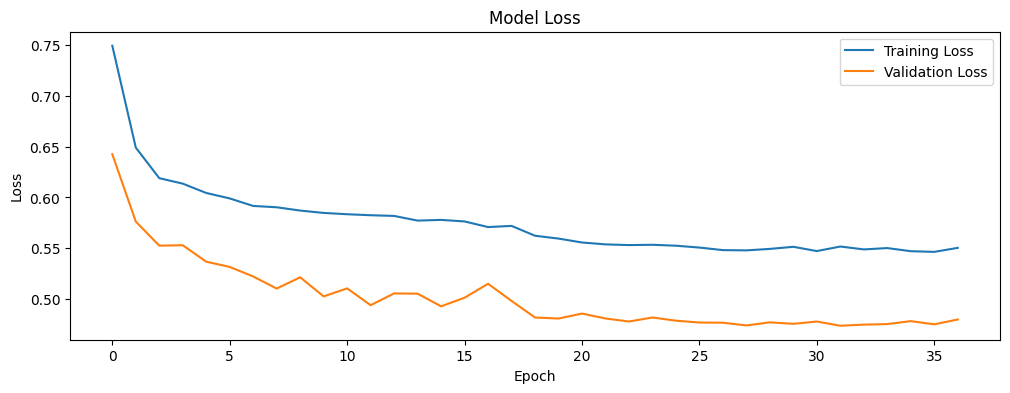

In [32]:
# visualize training history
plt.figure(figsize=(12, 4))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


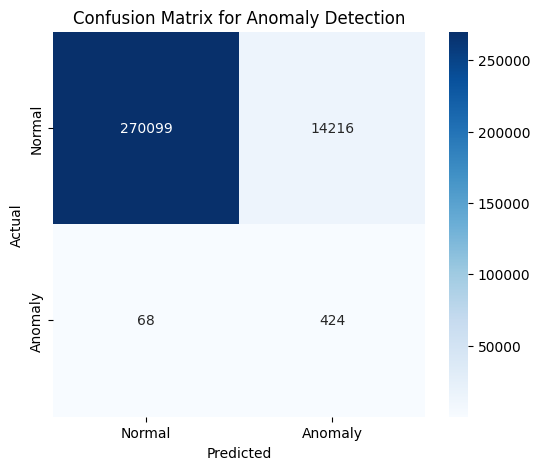

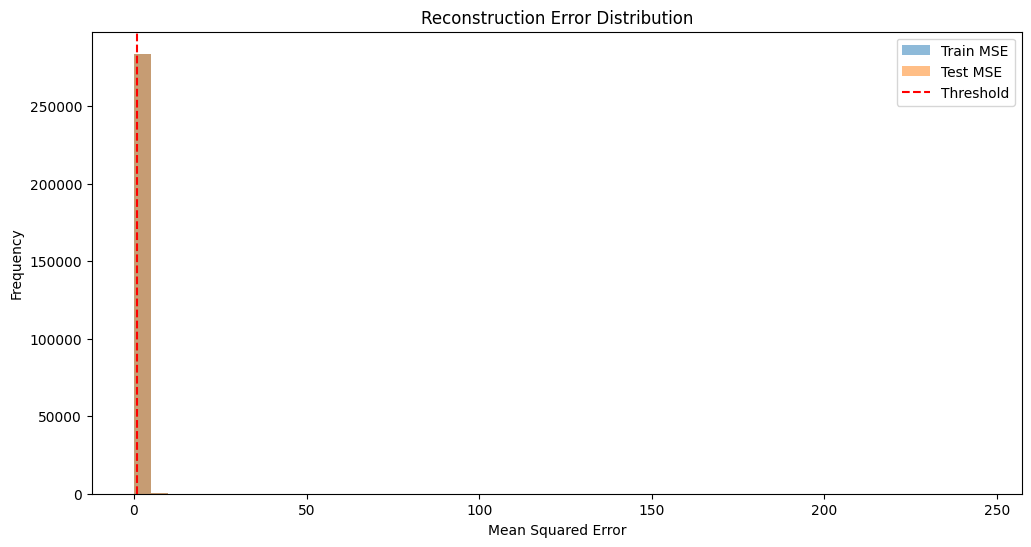

In [33]:
# visualize confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'Anomaly'], yticklabels=['Normal', 'Anomaly'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for Anomaly Detection')
plt.show()

# visualize reconstruction errors
plt.figure(figsize=(12, 6))
plt.hist(train_mse, bins=50, alpha=0.5, label='Train MSE')
plt.hist(test_mse, bins=50, alpha=0.5, label='Test MSE')
plt.axvline(threshold, color='red', linestyle='--', label='Threshold')
plt.title('Reconstruction Error Distribution')
plt.xlabel('Mean Squared Error')
plt.ylabel('Frequency')
plt.legend()
plt.show()

In [35]:
# save model
model_dir = project_dir + '/model'
os.makedirs(model_dir, exist_ok=True)
model_filename = model_dir + 'creditcard_autoencoder.h5'
autoencoder.save(model_filename)
print(f'Model saved as {model_filename}')


Model saved as ./18_autoencoders/modelcreditcard_autoencoder.h5


In [36]:
# load and test with sample transactions
loaded_model = tf.keras.models.load_model(model_filename)

# select 10 normal and 10 anomalous sample transactions
normal_indices = np.where(y == 0)[0][:10]
anomaly_indices = np.where(y == 1)[0][:10]
sample_indices = np.concatenate([normal_indices, anomaly_indices])
sample_data = X_scaled[sample_indices]
sample_labels = y[sample_indices]

# shuffle samples
indices = np.arange(20)
np.random.shuffle(indices)
sample_data = sample_data[indices]
sample_labels = sample_labels[indices]

# test samples
results = []
for i, (sample, true_label) in enumerate(zip(sample_data, sample_labels)):
    sample_pred = loaded_model.predict(sample[np.newaxis, :], verbose=0)
    mse = np.mean(np.square(sample - sample_pred[0]))
    pred_label = "Anomaly" if mse > threshold else "Normal"
    results.append({
        "Transaction": f"Sample {i+1}",
        "True Label": "Normal" if true_label == 0 else "Anomaly",
        "Predicted Label": pred_label,
        "Reconstruction Error": mse
    })

# create results table
results_df = pd.DataFrame(results)
print("\nAnomaly Detection Results:")
print(results_df[["Transaction", "True Label", "Predicted Label", "Reconstruction Error"]].to_string(index=False))

# count correct and incorrect predictions
correct_count = sum(1 for result in results if result["True Label"] == result["Predicted Label"])
incorrect_count = len(results) - correct_count
print(f"\nPrediction Summary:")
print(f"Correct Predictions: {correct_count}")
print(f"Incorrect Predictions: {incorrect_count}")


Anomaly Detection Results:
Transaction True Label Predicted Label  Reconstruction Error
   Sample 1     Normal          Normal              0.254187
   Sample 2     Normal          Normal              0.956196
   Sample 3     Normal          Normal              0.194846
   Sample 4    Anomaly         Anomaly             18.947920
   Sample 5     Normal          Normal              0.648464
   Sample 6    Anomaly         Anomaly              2.682667
   Sample 7     Normal          Normal              0.155254
   Sample 8    Anomaly         Anomaly              3.400269
   Sample 9     Normal          Normal              0.148826
  Sample 10    Anomaly          Normal              0.823764
  Sample 11    Anomaly         Anomaly              8.094520
  Sample 12    Anomaly         Anomaly              9.046498
  Sample 13     Normal          Normal              0.366362
  Sample 14    Anomaly         Anomaly              1.906697
  Sample 15    Anomaly         Anomaly              5.463